## Determine test set files.

In [1]:
import os

input_dir = "L2/testing_set/images"
target_dir = "L2/testing_set/masks"
gt_dir = "L2/testing_set/groundtruth"

img_size = (224, 160)
num_classes = 3
batch_size = 1

test_input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
test_gt_paths = sorted(
    [
        os.path.join(gt_dir, fname)
        for fname in os.listdir(gt_dir)
        if fname.endswith(".csv")
    ]
)

tot_num_images =  len(test_input_img_paths)
print("Number of samples:", len(test_input_img_paths))

for input_path, target_path in zip(test_input_img_paths[:10], test_target_img_paths[:2]):
    print(input_path, "|", target_path)

Number of samples: 10
L2/testing_set/images\000008437_Ycrop_Hres_L.png | L2/testing_set/masks\000008437_Ycrop_Hres_L.png
L2/testing_set/images\000008491_Ycrop_Hres_R.png | L2/testing_set/masks\000008491_Ycrop_Hres_R.png


In [2]:
# load the trained model
import tensorflow.keras as keras
model = keras.models.load_model('eyepupil_segmentation.h5')
#model.summary()

## Define the EyePupil class for reading

In [3]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class EyePupil(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
        return x, y

In [203]:
# Generate predictions for all images in the validation set
test_gen = EyePupil(batch_size, img_size, test_input_img_paths, test_target_img_paths)
test_preds = model.predict(test_gen)
test_preds.shape

(10, 224, 160, 3)

In [325]:
class Eye():
    def __init__(self, image, mask):
        self.image = image
        self.mask = mask
        self.rows, self.cols = mask.shape
        self.Iris = mask.copy()
        self.Pupil = mask.copy()
        self.EdgeIris=[]
        self.EdgePupil=[]
    def getIris (self): # function for visualization of the Iris. Just gets the bounding box
        cur_row = 0
        self.Iris=self.mask.copy()
        for r in range(self.rows):
            if sum(self.mask[r,:])==0:
                self.Iris = np.delete(self.Iris,cur_row,0)
            else:
                cur_row += 1
        cur_col = 0
        for c in range(self.cols):
            if sum(self.mask[:,c])==0:
                self.Iris = np.delete(self.Iris, cur_col,1)
            else:
                cur_col += 1
    def getPupil (self): # for visualization of the Pupil.
        self.getIris()
        self.Pupil=(self.Iris<1.05) * (self.Iris>0.95)
        maskPupil = self.Pupil.copy()
        rows, cols = self.Pupil.shape
        cur_row=0
        for r in range(rows):
            if sum(maskPupil[r,:]) < 5:
                self.Pupil = np.delete(self.Pupil, cur_row,0)
            else:
                cur_row += 1
        cur_col=0
        for c in range(cols):
            if sum(maskPupil[:,c]) < 5:
                self.Pupil = np.delete(self.Pupil, cur_col,1)
            else:
                cur_col += 1
    def CollectEdgePoints (self, maskedImage):
        # collect Edge points, i.e. those including "enough" neighbors: empirical result.
        delta = 3
        aread = (delta+1)**2
        EdgePoints = []
        for r in range(delta, self.rows-delta):
            for c in range(delta, self.cols-delta):
                nbs = sum(sum(maskedImage[r-delta:r+delta+1,c-delta:c+delta+1]))
                if (nbs < aread*3/4) and (nbs > aread / 4):
                    EdgePoints.append([r,c])
        # display the collected Edge points
        Edge=np.zeros((self.rows,self.cols))
        counter=0
        for r,c in EdgePoints:
            Edge[r,c]=255
            counter+=1
        #print('Number of Edge points found: ', counter)
        #Edge=Edge>0.5
        #img=PIL.Image.fromarray(Edge)
        #display(img)
        return EdgePoints
    def FindElipseData (self, EdgePoints):
        E=np.array(EdgePoints)
        Xi=E[:,0]
        MaxX=max(Xi)
        Xi=Xi/MaxX
        Yi=E[:,1]
        MaxY=max(Yi)
        Yi=Yi/MaxY
        # there are 5 elipse indeterminates B, C, D , E F
        # x^2 + B x y + C y^2 + D x + E y + F = 0
        M=np.zeros((5,5))
        U=np.zeros((5,1))

        for i in range(len(Xi)):
            x=Xi[i]
            y=Yi[i]
            M[0,0] += x * y * x * y
            M[0,1] += x * y * y * y
            M[0,2] += x * y * x
            M[0,3] += x * y * y
            M[0,4] += x * y

            M[1,1] += y * y * y * y
            M[1,2] += y * y * x
            M[1,3] += y * y * y
            M[1,4] += y * y

            M[2,2] += x * x
            M[2,3] += x * y
            M[2,4] += x

            M[3,3] += y * y
            M[3,4] += y

            M[4,4] += 1

            U[0] += x * y * x * x
            U[1] += y * y * x * x
            U[2] += x     * x * x
            U[3] +=     y * x * x
            U[4] +=         x * x

        M = M + np.transpose(M) - np.diag(np.diag(M))

        U=-U
        Coeffs = np.matmul (np.linalg.inv(M), U)
        # TODO: add robustness to the process: points with big error (i.e. when plug in x, y into ellipse equation)
        #       and the result is big in abs, this point can be eliminated.
        A=1/MaxX/MaxX
        B = Coeffs[0][0]/MaxX/MaxY
        C = Coeffs[1][0]/MaxY/MaxY
        D = Coeffs[2][0]/MaxX
        E = Coeffs[3][0]/MaxY
        F = Coeffs[4][0]
        M0=[[F ,D/2, E/2],[D/2, A, B/2],[E/2,B/2,C]]
        Mt=[[A,B/2],[B/2,C]]
        lambdas=np.linalg.eig(Mt)
        a=math.sqrt(-np.linalg.det(M0)/(np.linalg.det(Mt)*lambdas[0][0]))
        b=math.sqrt(-np.linalg.det(M0)/(np.linalg.det(Mt)*lambdas[0][1]))

        # fromulas from slide 17, 
        # h in the slides
        coord_x = round((B*E-2*C*D) / (4*A*C-B*B),2)
        # k in the slides
        coord_y = round((B* D - 2 * A * E) / (4*A*C-B*B),2)
        radiusX = round(a,2)
        radiusY = round(b,2)
        theta = round(np.arctan((A-C)/B)/2,2)
        return [coord_x, coord_y, radiusX, radiusY, theta]
    def getPupilData(self): # Assumes that
        maskedImage = self.mask > 0.95
        EdgePoints = self.CollectEdgePoints (maskedImage)
        data = self.FindElipseData (EdgePoints)
        return data
    def getIrisData (self):
        # Collect Edge Iris Points into IrisR
        maskedImage = (self.mask < 1.05) * (self.mask > 0.95)
        EdgePoints = self.CollectEdgePoints (maskedImage)
        data = self.FindElipseData (EdgePoints)
        return data


## Display a list of results for the validation dataset.

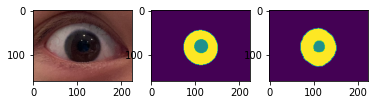

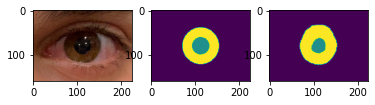

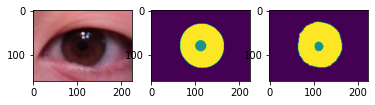

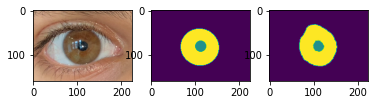

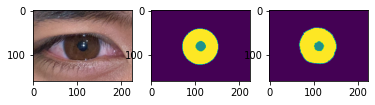

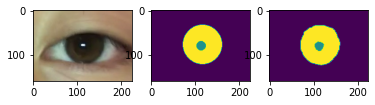

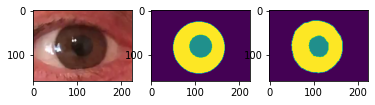

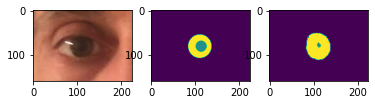

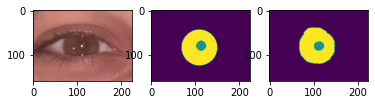

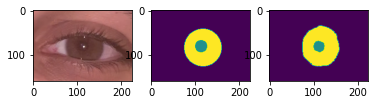

In [323]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import PIL
from PIL import ImageOps
from numpy import asarray
imgD=[]

for i in range(10):
    f,ax = plt.subplots(1,3)
    img1=imread(test_input_img_paths[i])
    ax[0].imshow(img1)
    img2 = imread(test_target_img_paths[i]) 
    ax[1].imshow(img2)
    mask = np.argmax(test_preds[i], axis=-1)    
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    img = img.resize(img_size)
    ax[2].imshow(img)

plt.show() # or display.display(plt.gcf()) if you prefer

In [313]:
# TEST functions
#  ------------------------------------
# i = 4
# mask = np.argmax(test_preds[i], axis=-1)
# testeye=Eye(test_input_img_paths[i], mask)
# testeye.getIrisData()
# testeye.getPupilData()
# testeye.getIris()
# plt.matshow(testeye.Iris)
# testeye.getPupil()
# plt.matshow(testeye.Pupil)

## Create metrics for the test files

In [314]:
import pandas as pd

testGroundTruth = []

for fn in test_gt_paths:
    df = pd.read_csv (fn)
    testGroundTruth.append(df.to_numpy()[0][:-1])
print(testGroundTruth)

[array([112.    ,  80.    ,  14.53  ,  14.53  ,   0.    , 111.    ,
        83.    ,  39.478 ,  38.367 ,  60.0514]), array([112.   ,  80.   ,  19.276,  19.276,   0.   , 111.   ,  80.   ,
        40.745,  40.745,   0.   ]), array([112.   ,  80.   ,  11.6  ,  11.6  ,   0.   , 114.   ,  79.   ,
        49.702,  49.001,  46.049]), array([112.    ,  80.    ,  11.755 ,  11.755 ,   0.    , 110.    ,
        82.    ,  42.971 ,  41.071 ,  14.8961]), array([112.   ,  80.   ,  11.481,  11.481,   0.   , 110.   ,  81.   ,
        40.397,  40.397,   0.   ]), array([112.   ,  80.   ,   9.625,   9.625,   0.   , 115.   ,  77.   ,
        43.729,  43.729,   0.   ]), array([112.   ,  80.   ,  24.722,  24.722,   0.   , 108.   ,  84.   ,
        57.553,  57.553,   0.   ]), array([112.   ,  80.   ,  11.595,  11.595,   0.   , 109.   ,  81.   ,
        26.14 ,  26.14 ,   0.   ]), array([112.   ,  80.   ,  10.826,  10.826,   0.   , 108.   ,  83.   ,
        39.83 ,  39.83 ,   0.   ]), array([112.   ,  80.   , 

In [340]:
print( ['coord_p_x','coord_p_y','radiusX_p','radiusY_p','theta_p','coord_i_x','coord_i_y','radius_X_i','radiusY_i','theta_i'])
mean=np.zeros((1,10))
for i in range(10):
    img = test_input_img_paths[i]
    mask = np.argmax(test_preds[i], axis=-1)
    testeye=Eye(test_input_img_paths[i], mask)
    testIrisdata  = testeye.getIrisData()
    testPupilData = testeye.getPupilData()
    print('**************** ','sample # ',i,' ****************')
    print(np.concatenate((testIrisdata, testPupilData))-np.array(testGroundTruth[i][:]))
    mean += np.concatenate((testIrisdata, testPupilData))-np.array(testGroundTruth[i][:])
mean /= 10
print('+++++++++++++++++++++++++++++++++++++++++++++++++++++')
print('******************* mean ***************************')
print(mean)

['coord_p_x', 'coord_p_y', 'radiusX_p', 'radiusY_p', 'theta_p', 'coord_i_x', 'coord_i_y', 'radius_X_i', 'radiusY_i', 'theta_i']
****************  sample #  0  ****************
[  2.84     0.58     5.87    -2.92    -0.75     5.81    -3.86    21.612
  -7.327  -59.2814]
****************  sample #  1  ****************
[ 0.66  -0.03   6.204 -5.646 -0.72  -1.58  -0.57  24.885 -8.795 -0.77 ]
****************  sample #  2  ****************
[  2.41    0.13    4.99   -2.16    0.77   -4.62    2.66   24.768 -10.741
 -45.269]
****************  sample #  3  ****************
[  1.38    -0.52     7.315   -1.025    0.74     2.77    -3.63    23.519
  -8.771  -14.1561]
****************  sample #  4  ****************
[ 2.15   0.25   5.359 -1.581  0.78   2.93  -2.54  19.253 -8.277  0.76 ]
****************  sample #  5  ****************
[ 1.52   0.62   6.315 -0.165  0.78  -6.05   5.11  21.621 -9.479 -0.78 ]
****************  sample #  6  ****************
[  2.42    0.     10.788  -6.492   0.76    6.91   -6.

## Finding Ellipse fitting data
materila from here: https://www.cs.cornell.edu/cv/OtherPdf/Ellipse.pdf
The following lines demonstrate the process how the Ellipse parameters were found (with images)!!!!

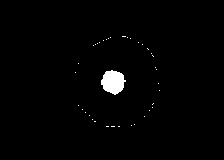

In [173]:
mask = np.array(imgD[9])
Pupil=(mask<127+20) * (mask>127-20)
display(PIL.Image.fromarray(Pupil))

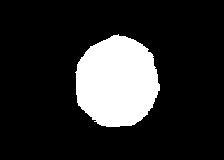

In [175]:
# Collect Edge Iris Points into IrisR
mask = np.array(imgD[9])
IrisR = mask>127-20
display(PIL.Image.fromarray(IrisR))
# collect robust Edge points only, i.e. those including "enough" neighbors: empirical result.
ros, cols = mask.shape
delta = 3
aread = (delta+1)**2
EdgeIris = []
for r in range(delta, rows-delta):
    for c in range(delta, cols-delta):
        nbs = sum(sum(IrisR[r-delta:r+delta+1,c-delta:c+delta+1]))
        if (nbs < aread*3/4) and (nbs > aread / 4):
            EdgeIris.append([r,c])

324


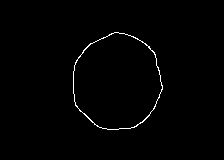

In [176]:
# Display the collected Edge points
Edge=np.zeros((rows,cols))
counter=0
for r,c in EdgeIris:
    Edge[r,c]=255
    counter+=1
print(counter)
Edge=Edge>0.5
img=PIL.Image.fromarray(Edge)
display(img)

In [177]:
E=np.array(EdgeIris)
Xi=E[:,0]
MaxX=max(Xi)
Xi=Xi/MaxX
Yi=E[:,1]
MaxY=max(Yi)
Yi=Yi/MaxY
# there are 5 elipse indeterminates B, C, D , E F
# x^2 + B x y + C y^2 + D x + E y + F = 0
M=np.zeros((5,5))
U=np.zeros((5,1))

for i in range(len(Xi)):
    x=Xi[i]
    y=Yi[i]
    M[0,0] += x * y * x * y
    M[0,1] += x * y * y * y
    M[0,2] += x * y * x
    M[0,3] += x * y * y
    M[0,4] += x * y
    
    M[1,1] += y * y * y * y
    M[1,2] += y * y * x
    M[1,3] += y * y * y
    M[1,4] += y * y

    M[2,2] += x * x
    M[2,3] += x * y
    M[2,4] += x

    M[3,3] += y * y
    M[3,4] += y
    
    M[4,4] += 1
     
    U[0] += x * y * x * x
    U[1] += y * y * x * x
    U[2] += x     * x * x
    U[3] +=     y * x * x
    U[4] +=         x * x

M = M + np.transpose(M) - np.diag(np.diag(M))
    
U=-U
Coeffs = np.matmul (np.linalg.inv(M), U)

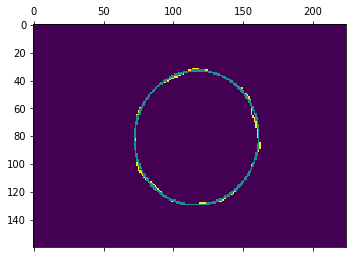

In [178]:
# Disply Edge And Ellipse
Edge=np.zeros((rows,cols))

for r,c in EdgeIris:
    Edge[r,c]=255

for x in range(80 - 50,80 + 50,1):
    for y in range(112 - 50,112 + 50,1):
        xn = x/MaxX
        yn = y/MaxY
        error = np.matmul([xn*yn, yn*yn, xn, yn, 1], Coeffs) + xn*xn
        error = abs(error[0])
        if error < 0.005:
            Edge[x,y]=127

plt.matshow(Edge)


In [198]:
import math
A=1/MaxX/MaxX
B = Coeffs[0][0]/MaxX/MaxY
C = Coeffs[1][0]/MaxY/MaxY
D = Coeffs[2][0]/MaxX
E = Coeffs[3][0]/MaxY
F = Coeffs[4][0]
M0=[[F ,D/2, E/2],[D/2, A, B/2],[E/2,B/2,C]]
Mt=[[A,B/2],[B/2,C]]
lambdas=np.linalg.eig(Mt)
a=math.sqrt(-np.linalg.det(M0)/(np.linalg.det(Mt)*lambdas[0][0]))
b=math.sqrt(-np.linalg.det(M0)/(np.linalg.det(Mt)*lambdas[0][1]))

# fromulas from slide 17.
# h in the slides
coord_x = (B * E - 2 * C * D) / (4*A*C-B*B)
# k in the slides
coord_y = (B * D - 2 * A * E) / (4*A*C-B*B)
radiusX = a
radiusY = b
theta = np.arctan((A-C)/B)/2
[coord_x, coord_y, radiusX, radiusY, theta]

[81.58127512962042,
 116.61224938852527,
 48.096520188005464,
 44.39172694826302,
 -0.6765587135407253]